# Time series methods in Finance - ARIMA Models 

- Author: Mathis Mourey
- Date: 26/03/2024

In [46]:
# Some aesthetics options 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the Economist-style color palette
economist_colors = ['#E3120B', # Red
                    '#005689', # Blue
                    '#6B6E68', # Grey
                    '#FFB81C', # Yellow
                    '#8F253B', # Wine
                    '#AAAAB4'] # Light Grey

# Apply the style settings
plt.style.use('classic') # Use a classic style as the base

mpl.rcParams.update({
    # Use serif font similar to The Economist's
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    
    # Set the figure background and axes face color
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    
    # Set the color of the gridlines
    'grid.color': 'lightgrey',
    
    # Set titles and labels size
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    
    # Set the ticks parameters
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    
    # Set the legend parameters
    'legend.frameon': False,
    'legend.fontsize': 12,
    
    # Set the lines parameters
    'lines.linewidth': 2,
    'lines.markersize': 6,
    
    # Set the plot edges and grid
    'axes.edgecolor': 'grey',
    'axes.grid': True,
    'grid.alpha': 0.5,
})

import warnings
warnings.filterwarnings("ignore")

## Auto Regressive (AR) models
***

### What are AR Models?

Autoregressive Models are a type of statistical model used for forecasting future values in a time series. They are based on the premise that current observations are correlated with previous observations. The general form of an AR model of order \($p$\) (denoted as $AR(p)$) is given by:

$$
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \epsilon_t
$$

$$
Y_t = c + \sum \limits_{i=1}^{p}\phi_i Y_{t-i} + \epsilon_t
$$

Where:
- $Y_t$ is the value of the series at time $t$,
- $c$ is a constant,
- $\phi_1, \phi_2, \dots, \phi_p$ are the parameters of the model,
- $p$ is the order of the autoregression, indicating the number of lagged observations in the model,
- $\epsilon_t$ is white noise (error term) at time $t$.


### When to prefer AR Models:

Autoregressive (AR) models are particularly suited for time series data where the future value of a variable is believed to depend linearly on its own previous values. These models are widely applicable in various scenarios across finance, economics, weather forecasting, and more. Here are some specific cases where using an AR model would be appropriate:
o Prefer AR Models:
- **Stationarity**: The time series should be stationary, meaning its statistical properties like mean and variance do not change over time. AR models are best suited for data that return to a long-term mean.
- **Autocorrelation Presence**: There should be a significant autocorrelation in the time series, i.e., past values should have a linear relationship with current values. This is usually checked using a correlogram or partial autocorrelation function (PACF).
- **Simplicity and Interpretability**: When the goal is to use a model that is easy to understand and interpret, AR models offer a straightforward approach compared to more complex models like ARIMA (Autoregressive Integrated Moving Average) or GARCH (Generalized Autoregressive Conditional model may be necessary.


Let's import some financial data from the stock market and try to identify when a timeseries is actually stationary and that there is some evidence of autocorrelation.

In [10]:
import yfinance as fyf 

In [80]:
ticker = 'AAPL'

# get daily stock data
price = fyf.download(ticker, '2010-01-01', '2018-01-01')['Adj Close']

# let's study weekly stock returns 
weekly_price = price.resample('W').last()
weekly_rt = weekly_price.pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


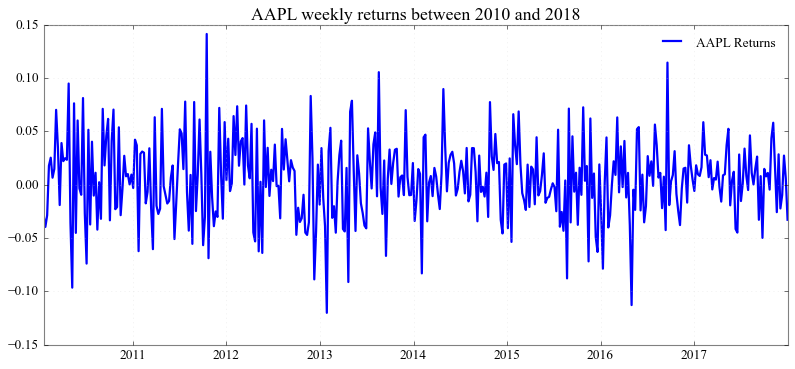

In [35]:
plt.figure(figsize=(12,5))
plt.title('AAPL weekly returns between 2010 and 2018')
plt.plot(weekly_rt, label='AAPL Returns')
plt.legend()
plt.show()

To test for stationarity, we use the ADF (Augmmented Dickey-Fuller) test. If you haven't heard of this test yet, then feel free to jump to the notebook **TimeSeries Stationarity** to get some primer on the approach.

In [36]:
from statsmodels.tsa.stattools import adfuller

# Compute the ADF
adf_test = adfuller(weekly_rt)

# Output results
print('The statistics is : '+str(adf_test[0]))
print('The p-value is : '+str(adf_test[1]))

The statistics is : -22.51411407614187
The p-value is : 0.0


We find that the p-value is lower than 5% so we can accept that the serie is stationnary! 

Let's now check is there is the presence of autocorrelation in the returns. For this, we use the PACF plots. To see some details about partial autocorrelation, you can refer to the **TimeSeries Stationarity** notebook. 

<Figure size 960x400 with 0 Axes>

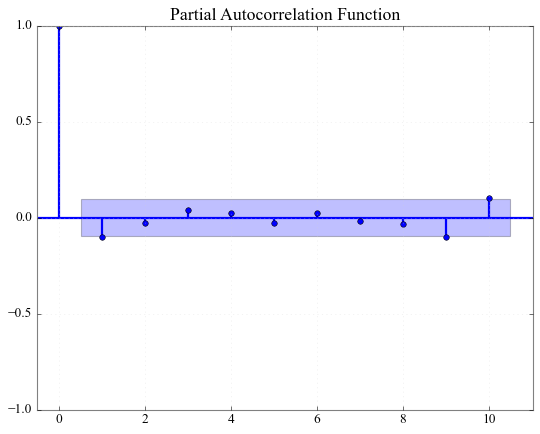

In [40]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf


# Compute the PACF
partial_autocorrelation = pacf(weekly_rt, nlags=20, method='ywadjusted')

# Plot the PACF
plt.figure(figsize=(12, 5))
plot_pacf(weekly_rt, lags=10, method='ywadjusted')
plt.title('Partial Autocorrelation Function')
plt.show()

It is here unclear whether some autocorrelation exists. It might be some autocorrelation for lags 1, 9 10, 12 and 17. But it looks weak. We'll see whether this transpires in the results of the AR model!

**Considerations**:
While AR models are versatile, they are not suitable for every scenario. For example, if the data exhibits significant seasonal patterns, trend components, or if there are exogenous (external) variables that significantly influence the variable being forecasted, more complex models or extensions of the AR model may be necessary.


### Simple Example:

Consider a simplified scenario where we aim to forecast tomorrow's stock return based on today's return. We assume the stock return follows an AR(1) model:

$$R_t = c + \phi R_{t-1} + \epsilon_t $$

Let's say after analyzing historical stock price data, we determine:
- $c = 0.5$,
- $\phi = 0.9$.

Using these parameters, if today's stock return ($R_{t-1}$) is 10%, our forecast for tomorrow's returns ($R_t$) would be:

$$ R_t = 0.5 + 0.9 \times 10 + \epsilon_t $$

Assuming $\epsilon_t$ is negligible for this example, the forecasted price for tomorrow would be 9.5%.

### How do we decide on how much lags to use? (p order)



The first step in modeling with AR models is determining the appropriate order $p$. This is crucial because an overly complex model (high 
 $p$) may lead to overfitting, while an overly simplistic model may not capture the underlying process accurately. Methods to determine 
$p$ include:

- **AIC** (Akaike Information Criterion): Looks for the model that best explains the data with a minimum number of parameters.
- **BIC** (Bayesian Information Criterion): Similar to AIC but with a stricter penalty for the number of parameters, favoring simpler models.
- **PACF** (Partial Autocorrelation Function): Examines the partial correlation of a variable with its own lagged values, controlling for the values of the time series at all shorter lags. A sharp cut-off in the PACF suggests the order of the AR model.

We already presented the PACF approach above so we will stick with this one for now, but most packages can provide some information about AIC and BIC. 

### AR: Implementation on market data

In [39]:
from statsmodels.tsa.ar_model import AutoReg as AR

# Fit an AR model. Here, we choose lag 10 based on the PACF
model = AR(weekly_rt, lags=10)
model_fitted = model.fit()

# Summary of the model
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:              Adj Close   No. Observations:                  416
Model:                    AutoReg(10)   Log Likelihood                 766.547
Method:               Conditional MLE   S.D. of innovations              0.037
Date:                Wed, 27 Mar 2024   AIC                          -1509.094
Time:                        08:05:00   BIC                          -1461.018
Sample:                    03-28-2010   HQIC                         -1490.066
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0056      0.002      2.762      0.006       0.002       0.010
Adj Close.L1     -0.1070      0.049     -2.167      0.030      -0.204      -0.010
Adj Close.L2     -0.0191      0.049     

The ```statsmodels``` package is indeed giving us the AIC and BIC to help us choose between different models (if we would be trying different models with different lag orders).  

Looking at the p-values, we find that only the lags 1, 9 and 10 are below the 10% level. Is this surprising? Not really :) This is what the pacf already indicated. 

It's important to note that here, the constant (```const```) indicates the long-term average of the timeseries. If we compare it to the historical average return of AAPL returns, we do find it close: 

```python
print(weekly_rt.mean())
>>> 0.0051
```

Let's see now visually how is our model fitting our data in sample. 

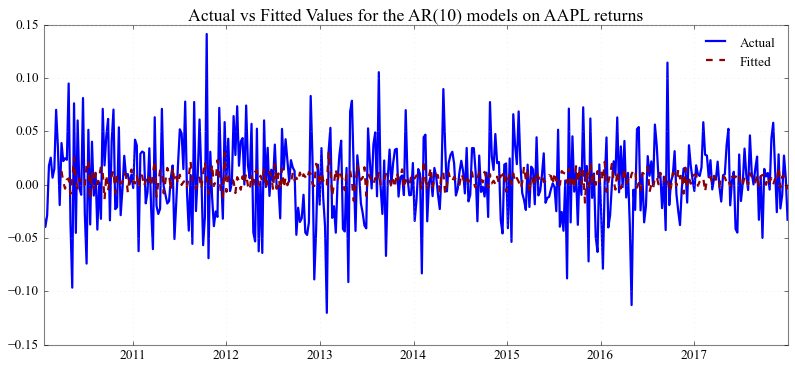

In [48]:
in_sample_preds = model_fitted.predict(start=10, end=len(weekly_rt)-1, dynamic=False) #start has to be at the lag level

# Plotting actual vs. fitted values
plt.figure(figsize=(12, 5))
plt.plot(weekly_rt, label='Actual')
plt.plot(in_sample_preds, label='Fitted', color='darkred', linestyle='--')
plt.title('Actual vs Fitted Values for the AR(10) models on AAPL returns')
plt.legend()
plt.show()

Hm, the fit does not look great. But, again, is that surprising? 

Not particularly. We know that financial timeseries are mostly random (hence difficult to predict determiniscally). Also, the PACF plot was already showing very weak serial correlation. If a PACF would highlight higher autocorrelation then the AR model would be more powerful in the modelling of that series!

Alright, let's still try to predict future returns using this model. And **keeping in mind that our model has a lot of limitations** :) 

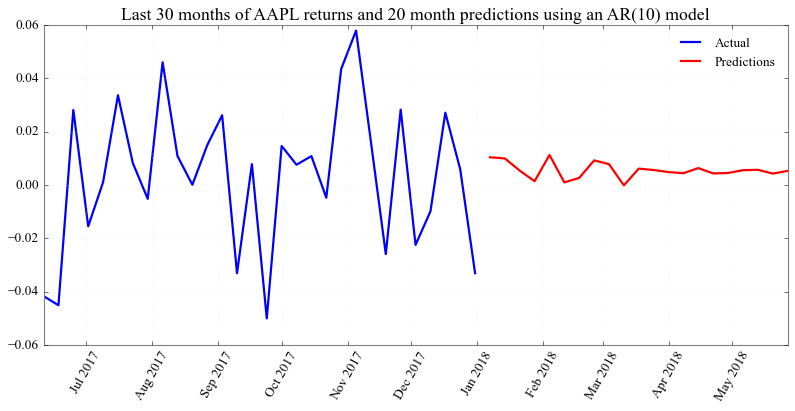

In [56]:
predictions = model_fitted.predict(start=len(weekly_rt), end=len(weekly_rt)+20)

plt.figure(figsize=(12,5))
plt.plot(weekly_rt[-30:], label='Actual')
plt.plot(predictions, label='Predictions', color='red')
plt.title('Last 30 months of AAPL returns and 20 month predictions using an AR(10) model')
plt.legend()
plt.xticks(rotation=60)
plt.show()

Well. That does not seem overly convincing! But that is good news. If predicting the stock market was so simple then the world would be a greatly different place. More seriously, if a simple model would be capable of predicting future returns, investors would all use this model to pursue a winning strategies, their own behaviour would then change the dynamics of the market, making this model moot for use. In finance, a "good" predicting model cannot last long (except if it is only known by a small amount of investors).  

In the next sections, let's discover together other types of models to go further into our comprehension of timeseries dynamics in finance :)

## Moving Average (MA) models 
***

### What are MA Models?

Moving Average (MA) models are a core component of time series analysis within the field of statistics and econometrics, particularly useful for modeling and forecasting time series data. Unlike Autoregressive (AR) models that express the current value of the series as a linear function of its past values, Moving Average models explain the current value of the time series as a linear function of past error terms. This approach is particularly useful for modeling time series that exhibit short-term, shock-like patterns.

**Equation of an MA Model**

A Moving Average model of order \($q$\), denoted as $MA(q)$, is given by the equation:

$$ Y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q\epsilon_{t-q} $$

$$ Y_t = \mu + \epsilon_t + \sum\limits_{i=1}^{q}\theta_i\epsilon_{t-i} $$

Where:
- $Y_t$ is the value of the time series at time \(t\),
- $\mu$ is the mean of the series,
- $\epsilon_t$ is the white noise (error term) at time \(t\),
- $\theta_1, \theta_2, \ldots, \theta_q$ are the parameters of the model,
- $q$ is the order of the MA model, indicating the number of lagged forecast errors in the prediction equation.


**Key Characteristics**

- **Shocks and Persistence**: The MA model captures the idea that shocks to the time series (e.g., sudden increases or decreases due to external factors) can have a temporary effect that lasts for \($q$\) periods. The parameters \($\theta_i$\) determine the persistence and the damping effect of these shocks over time.

- **Stationarity**: Unlike some AR models, MA models are always stationary as they do not depend on the lagged values of the series itself but on the lagged error terms.

- **Forecasting**: MA models are particularly useful for forecasting when the impact of shocks or innovations is believed to dissipate over time. The forecast beyond \($q$\) periods into the future converges to the mean of the series, as the effects of past errors do not persist indefinitely.

MA models, along with AR models, form the basis for more complex models like ARIMA (Autoregressive Integrated Moving Average), which can handle a wider range of time series data, including non-stationary series.

### When to prefer MA Models:

Moving Average (MA) models are most coherent and applicable under certain conditions or characteristics of the time series data. They are particularly useful for modeling time series that exhibit specific kinds of behaviors or structures. Here are scenarios where MA models tend to be most coherent and effective:

1. **Short-Term Shock Effects**

MA models are adept at capturing the effects of short-term shocks or noise that influence the behavior of a time series. If these shocks have a temporary effect that diminishes over time, an MA model can effectively model this behavior by focusing on the error terms of past observations.

2. **Random Fluctuations**

When a time series is characterized by random fluctuations without a clear long-term trend or seasonal patterns, MA models can be useful. They are good at smoothing out noise and highlighting the underlying signal in the data, especially when these fluctuations are thought to impact the series for only a limited period.

3. **White Noise Process**

An MA model is particularly coherent in situations where the time series is thought to follow a white noise process, with each value being a linear combination of past error terms. This is because MA models inherently rely on the concept that the current value of the series is influenced by the error terms (innovations) of its past values.

4. **Lack of Autoregressive Characteristics**

In cases where a time series does not exhibit strong autocorrelation or where the influence of past values on future values is not significant or direct, MA models may offer a better fit than AR models. This is because MA models focus on the error component rather than the values themselves.
deling the error structure is crucial for accurate forecasting.

5. **When ACF Cuts Off After a Few Lags**
   
The Autocorrelation Function (ACF) of a pure MA model of order \(q\) will exhibit a sharp cut-off after lag \(q\), indicating that MA models are coherent when the empirical ACF of the time series data shows this pattern.

**Considerations**

It's important to note that the choice between AR, MA, and more complex models like ARIMA depends on the specific characteristics of the time series data at hand. Often, preliminary analyses such as plotting the ACF and PACF, performing stationarity tests, and evaluating the residuals of fitted models are essential steps in identifying the most suitable model.

Let's then take a look at the ACF plot of our weely AAPL returns to see if an MA models would be more appropriate than an AR model!

<Figure size 960x400 with 0 Axes>

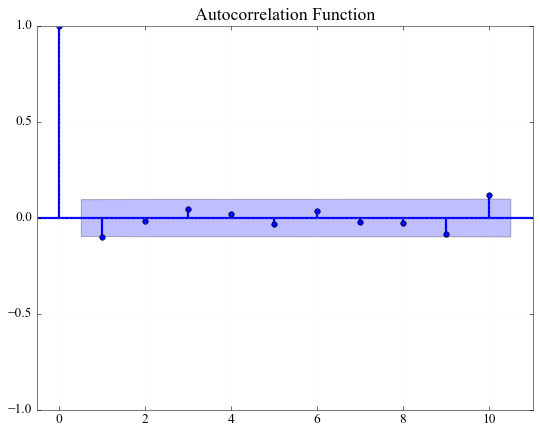

In [59]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


# Compute the ACF
autocorrelation = acf(weekly_rt, nlags=10)

# Plot the ACF
plt.figure(figsize=(12, 5))
plot_acf(weekly_rt, lags=10)
plt.title('Autocorrelation Function')
plt.show()

That doesn't look much nicer than the PACF plot. We do observe that there are two significant lags for lag order 1 and 10. But there is no clear cutoff in the lag order. 

We'll start with a simple example of how to compute an MA model and then move on to implement it with the actual market data for AAPL.

### Simple Example:

A Moving Average model of order 1, denoted as MA(1), can be represented by the following equation:

$$ Y_t = \mu + \epsilon_t + \theta \epsilon_{t-1} $$

Let's consider a simple MA(1) model with the following characteristics:
- \($\mu = 0$\) (for simplicity, we'll assume the process mean is zero),
- \($\theta = 0.5$\),
- The white noise \($\epsilon_t$\) is normally distributed with mean 0 and standard deviation 1, i.e., \($\epsilon_t \sim N(0, 1)$\).

Let's say that the error term, $ \epsilon_{t-1} $ was equal to 5% last week, and assuming that $ \epsilon_{t} $ is neglegible. Then the MA(1) model would predict the next return to be: 

$$ R_t = 0 + 0 + 0.5 * 5 = 2.5% $$

### How do we decide on how much lags to use? (q order)

Similarly to AR models, we decide on the lag order ( $q$ ) based on either of the following:  
- **AIC** (Akaike Information Criterion): Looks for the model that best explains the data with a minimum number of parameters.
- **BIC** (Bayesian Information Criterion): Similar to AIC but with a stricter penalty for the number of parameters, favoring simpler models.
- **ACF** (Autocorrelation Function): Examines the correlation of a variable with its own lagged values.  A sharp cut-off in the ACF suggests the order of the MA model.

### MA: Implementation on market data

Because the ACF plots is not the most conclusive, let's use the AIC score approach this time. 

We will simply fit MA models for increasing order of lags ($q$). So we will tart by fitting a MA(1) model, compute its AIC score. Then we will fit a MA(2) mode, compute its AIC score and keep going until a MA(10). Then we will simply stick with the model that has the minimum value for AIC.

Let's implement that in python: 

In [61]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

ma_orders = range(1, 12)

# Track AIC scores
aic_scores = []

for q in ma_orders:
    model = ARIMA(weekly_rt, order=(0, 0, q))
    model_fitted = model.fit()
    aic_scores.append(model_fitted.aic)

# Identify the order with the lowest AIC
optimal_q = ma_orders[aic_scores.index(min(aic_scores))]
print(f'Optimal MA order: {optimal_q}')

Optimal MA order: 1


So the MA(1) model seems to be the most relevant in our case: 

In [65]:
model = ARIMA(weekly_rt, order=(0, 0, 1))
model_fitted = model.fit()

# Print the summary of the model
print(model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  416
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 780.882
Date:                Wed, 27 Mar 2024   AIC                          -1555.763
Time:                        08:59:36   BIC                          -1543.671
Sample:                    01-17-2010   HQIC                         -1550.982
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      3.051      0.002       0.002       0.008
ma.L1         -0.1053      0.049     -2.160      0.031      -0.201      -0.010
sigma2         0.0014   8.38e-05     16.363      0.0

Here again, the lag 1 is significant (as the ACF plot was suggesting). And the constant term is again tending towards the historical average of the series. Let's see how the model compares visually!

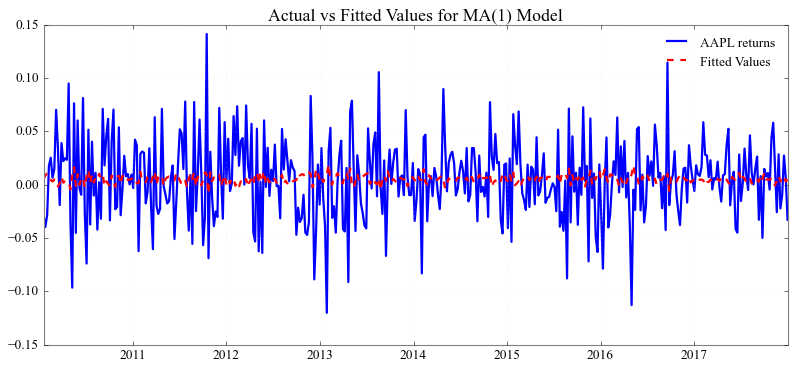

In [66]:
fitted_values = model_fitted.fittedvalues

# Plotting the actual vs fitted values
plt.figure(figsize=(12, 5))
plt.plot(weekly_rt, label='AAPL returns')
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('Actual vs Fitted Values for MA(1) Model')
plt.legend()
plt.show()

Well, it doesn't look much better than the AR(1) model. It is again not a big surprise, the low responses in the ACF plots were already evidence that the MA model will be weak at predicting weekly returns.

Anyways, let's see how the predictions compares to the AR(1) prediction: 

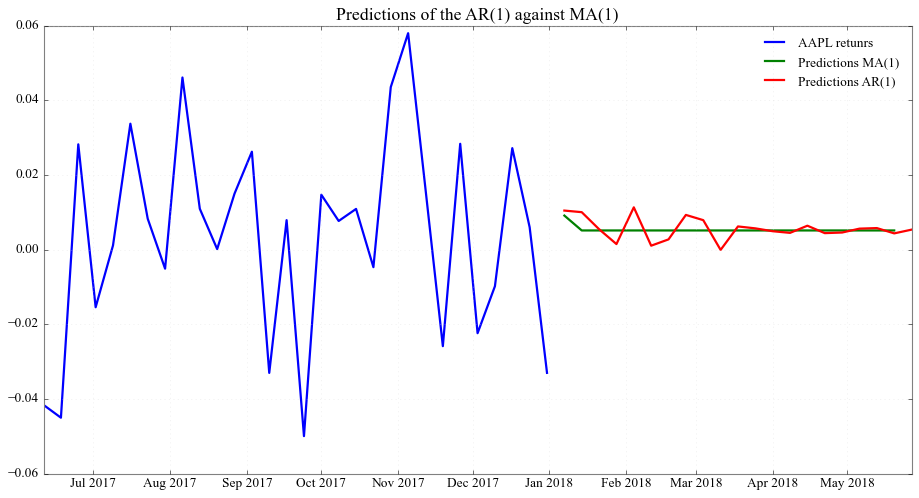

In [74]:
forecast = model_fitted.get_forecast(steps=20)
forecast_index = np.arange(len(weekly_rt), len(weekly_rt) + 20)

plt.figure(figsize=(14, 7))
plt.plot(weekly_rt[-30:], label='AAPL retunrs', color='blue')
plt.plot(forecast.predicted_mean, label='Predictions MA(1)', color='green')
plt.plot(predictions, label='Predictions AR(10)', color='red')
plt.title('Predictions of the AR(10) against MA(1)')
plt.legend()
plt.show()

For the most you, that will mostly likely look underwhelming :) 

What happens is that, after predicting over the lag order $q$ (which is 1 in our case), the prediction reverts automatically to the long term average (the constant term of the MA model). 

A relevant question is: "Does that make it a worse forecast than the AR(1)?". Not necessarily, sometimes having a simple forecast for the mean is more useful than a forecast that looks more complex :) 

Let's now address the question that some of you might have been thinking since the beginning of the MA models section: "Why the hell should I choose between an AR and a MA model? Why cannot I just do both at the same time?". I've got some good news for you then. You can! 

## Auto Regressive Moving Average (ARMA) Models
***

### What are ARMA Models?

ARMA models are utilized to understand and predict future points in a series by using a combination of autoregression (AR) and moving average (MA) models. An ARMA model is characterized by two parameters, \(p\) and \(q\), which represent the order of the autoregressive part and the moving average part, respectively. The ARMA model can be represented by the equation:

$$
Y_t = c + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t
$$

where:
- $Y_t$ is the time series at time \(t\),
- $c$ is a constant,
- $\epsilon_t$ is the error term at time \(t\),
- $p$ is the order of the autoregressive part,
- $q$ is the order of the moving average part,
- \($\phi_i$\) are the parameters of the autoregressive part for $i = 1, 2, ..., p$,
- \($\theta_j$\) are the parameters of the moving average part for $j = 1, 2, ..., q$.

Traditionally, the constant $c$ represents the long term average of the time series. Specifically, for financial returns, it will tend to the historical average of the series. 

### ARMA: Implementation on market data

Because we need to pick the right order for the AR and MA terms, namely $p$ and $q$, the choice is usually made via AIC or BIC. Since we already use AIC, let's use the Bayesian Information Criteria (BIC). 

In [97]:
import statsmodels.api as sm

p_range = range(1, 4)  # Adjust based on your data
q_range = range(1, 4)  # Adjust based on your data

best_bic = np.inf
best_order = None
best_model = None

for p in p_range:
    for q in q_range:
        model = sm.tsa.ARIMA(weekly_rt, order=(p,0,q)).fit()
        if model.bic < best_bic:
            best_bic = model.bic
            best_order = (p, q)
            best_model = model

# Print the best model
print(f"Best ARMA(p,q) Order: {best_order}")
print(f"Best Model's BIC: {best_bic}")

C:\Users\Mathis Mourey\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mathis Mourey\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mathis Mourey\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Mathis Mourey\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to co

Best ARMA(p,q) Order: (1, 1)
Best Model's BIC: -1537.6406132262775


We obtain that the best model is attained for the order (1,1). I would still recommend to try the procedure with more options (not juste 1 to 4 but maybe 1 to 10, although you might want to watch out for the time it will take to converge)

Let's now see how the model looks like and how relevant it is. 

In [102]:
model = sm.tsa.ARIMA(weekly_rt, order=(2,0,2))
model_fitted = model.fit()

# Print the summary of the model
print(model_fitted.summary())

C:\Users\Mathis Mourey\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  416
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 781.651
Date:                Fri, 29 Mar 2024   AIC                          -1551.302
Time:                        17:33:48   BIC                          -1527.118
Sample:                    01-17-2010   HQIC                         -1541.740
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.938      0.003       0.002       0.009
ar.L1         -0.3771      0.445     -0.847      0.397      -1.250       0.496
ar.L2         -0.6065      0.268     -2.263      0.0

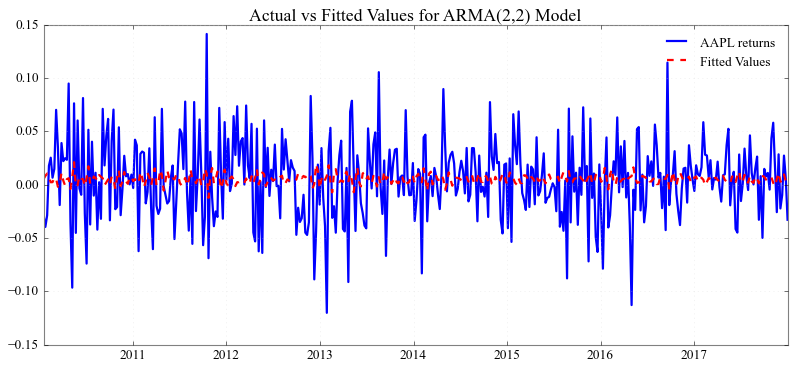

In [103]:
fitted_values = model_fitted.fittedvalues

# Plotting the actual vs fitted values
plt.figure(figsize=(12, 5))
plt.plot(weekly_rt, label='AAPL returns')
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('Actual vs Fitted Values for ARMA(2,2) Model')
plt.legend()
plt.show()

As we can see, the model still behaves poorly in explaining previous returns. This still is coherent with the previous observations we made: Financial returns are difficult to predict by nature. 

Let's observe how the predictions compare to the AR and MA models!

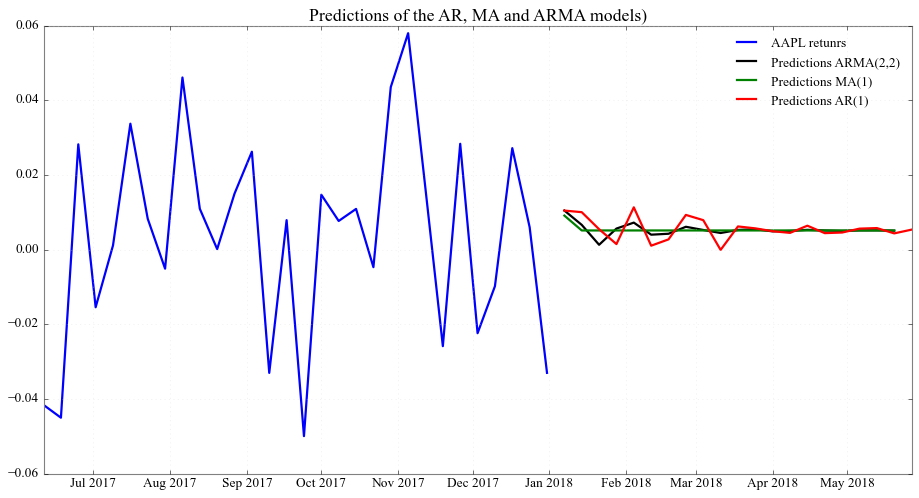

In [106]:
forecast_arma = model_fitted.get_forecast(steps=20)

plt.figure(figsize=(14, 7))
plt.plot(weekly_rt[-30:], label='AAPL retunrs', color='blue')
plt.plot(forecast_arma.predicted_mean, label='Predictions ARMA(2,2)', color='black')
plt.plot(forecast.predicted_mean, label='Predictions MA(1)', color='green')
plt.plot(predictions, label='Predictions AR(10)', color='red')
plt.title('Predictions of the AR, MA and ARMA models)')
plt.legend()
plt.show()

It should not be much of a surprise that an ARMA models tend to look like a compromise between an AR and MA model. The model keeps the prediction of an AR model and adds in the "return-towards-long-term-average" of the MA models. 

So is this the limits of ARMA models? Are they just not made for studying financial timeseries? 

It's too early to answer these questions :) We have two more variants to study: 
- Adding Integration in the model (ARIMA)
- Using Exogenous variables to help the model (ARIMAX)

## Auto Regressive Integrated Moving Average (ARIMA) Models
***

The ARIMA model, standing for AutoRegressive Integrated Moving Average, is a cornerstone of time series analysis. It serves to describe and forecast time series data by leveraging its own past values (autoregression), the differences of past values (integration), and past error terms (moving average). Essentially, ARIMA models are designed to understand and predict future points in a series by accounting for the inherent autocorrelations within the time series data.



### The ARIMA Equation:

The mathematical representation of an ARIMA model is:

$$  (1 - \sum_{i=1}^{p} \phi_i L^i) (1 - L)^d Y_t = c + (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t $$

where:
- $Y_t$ is the time series at time \(t\),
- $L$ is the lag operator,
- $c$ is the constant,
- $\phi_i$ are the parameters of the autoregressive part for $i = 1, 2, ..., p$,
- $\theta_j$ are the parameters of the moving average part for $j = 1, 2, ..., q$,
- $\epsilon_t$ is the error term at time $t$.
- $d$: The degree of differencing required to make the time series stationary. Stationarity is a crucial assumption for ARIMA models to function correctly. Differencing the series ($d$ times) helps stabilize the mean by removing trends and seasonality.


#### The Lag Operator $L$

The notation with the lag operator can often be confusing. Let's take a closer look on how this operator works. Simply put, whatever is multiplied by $L$ is pushed back one period back in time. If $L$ has an exponent, then the exponent indicates how many periods the variable is pushed back! Simple :)

For a first order difference:  $$L^1 X_t = X_{t-1}$$

So: $$ L^1 (X_t - X_{t-1}) = X_{t-1} - X_{t-2}$$

Hence: $$ L^d (X_t - X_{t-1}) = X_{t-d} - X_{t-d-1} $$

For a second order differencing: $$ (1 - L)^2 X_t = (1 - 2L + L^2) X_t = X_t - 2X_{t-1} + X_{t-2} $$


### Studying a few simple ARIMA models

To get a better idea of how this monster of equation for ARIMA works. Let's develop the equation for a few simple models. 

#### ARIMA(0,1,0)

We start with: 
$$ (1 - \sum_{i=1}^{p} \phi_i L^i) (1 - L)^d Y_t = c + (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t  $$

Because $p=0$, $q=0$ and $d=1$, and assuming $c=0$ for simplicity, we get:
$$ (1 - 0) (1 - L)^1 Y_t = (1 + 0) \epsilon_t  $$
$$ (1 - L) Y_t = \epsilon_t $$

Using the lag operator:
$$ Y_t - Y_{t-1} = \epsilon_t $$
$$ Y_t = Y_{t-1} + \epsilon_t$$

This is what is commonly known as a **random walk**. The variable is just the same as the past period with a white random shock ($\epsilon$ is usually standard normal). 





#### ARIMA(1,1,0)

We start with: 
$$ (1 - \sum_{i=1}^{p} \phi_i L^i) (1 - L)^d Y_t = c + (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t  $$

Subtituting $p=1$, $q=0$ and $d=1$, we get:

$$ (1 - \phi L)(1 - L) Y_t = c + (1 + 0) \epsilon_t  $$

Developping: 

$$ (1 - L)Y_t - ( \phi L(1-L)Y_t) = c + \epsilon_t$$
$$ Y_t - Y_{t-1} - (\phi (Y_{t-1} - Y_{t-2})) = c + \epsilon_t$$
$$ Y_t = c + Y_{t-1} + \phi (Y_{t-1}-Y_{t-2}) + \epsilon_t $$ 

In essence, the model follows a random walk with level $c$ and depends on the previous periodic change ($Y_{t-1} - Y_{t-2}$). 

Note that if you would like to go to higher levels of AR in the model, like an ARIMA(2,1,0), you will simply need to add the following: 
$$ Y_t = c + Y_{t-1} + \phi_1 (Y_{t-1}-Y_{t-2}) + \phi_2 (Y_{t-2}-Y_{t-3}) + \epsilon_t $$ 

Continuing for a $p$ order: 
$$ Y_t = c + Y_{t-1} + \phi_1 (Y_{t-1}-Y_{t-2}) + \phi_2 (Y_{t-2}-Y_{t-3}) + \dots + \phi_p (Y_{t-p}-Y_{t-p - 1}) + \epsilon_t $$

I will let you through the math to check that I didn't make a mistake :) 

#### ARIMA(1,2,0)

We start with: 
$$ (1 - \sum_{i=1}^{p} \phi_i L^i) (1 - L)^d Y_t = c + (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t  $$

Subtituting $p=1$, $q=0$ and $d=2$, we get:

$$ (1 - \phi_1 L)(1 - L)^2 Y_t = c + (1 + 0) \epsilon_t  $$

Developping: 

$$ (1 - L)^2Y_t - ( \phi_1 L(1-L)^2Y_t) = c + \epsilon_t$$
$$ (1 - 2L + L^2)Y_t - ( \phi_1 (L - 2L^2 + L^3) Y_t) = c + \epsilon_t$$
$$ Y_t - 2X_{t-1} + Y_{t-2} - ( \phi_1 (Y_{t-1} - 2Y_{t-2} + Y_{t-3 })) = c + \epsilon_t$$
$$ Y_t = 2X_{t-1} - Y_{t-2} c +  \phi_1 (Y_{t-1} - 2Y_{t-2} + Y_{t-3 }) +  \epsilon_t$$

A variable that is integrated of order 2 ($I(2)$) will depend from positively from the previous and negatively from the period before that. 

#### ARIMA(1,1,1)

We start with: 
$$ (1 - \sum_{i=1}^{p} \phi_i L^i) (1 - L)^d Y_t = c + (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t  $$

Subtituting $p=1$, $q=1$ and $d=1$, we get:

$$ (1 - \phi L)(1 - L) Y_t = c + (1 + \theta L) \epsilon_t  $$

Developping: 

$$ (1 - L)Y_t - ( \phi L(1-L)Y_t) = c + \epsilon_t + \theta \epsilon_{t-1}$$
$$ Y_t - Y_{t-1} - (\phi (Y_{t-1} - Y_{t-2}) = c + + \theta \epsilon_{t-1}+ \epsilon_t$$
$$ Y_t = c + Y_{t-1} + \phi (Y_{t-1}-Y_{t-2}) + + \theta \epsilon_{t-1} + \epsilon_t $$ 

### ARIMA: Implementation on market data 

The actual process of selecting an ARIMA model requires a lot of steps including testing the stationarity of the series and examining residuals for autocorrelation or non-normality. The pmdarima library's auto_arima function can automate much of this process, providing a more straightforward path to model selection. If pmdarima is not installed in your environment, you can install it using pip install pmdarima.

Let's use it to fit our ARIMA model on AAPL stock returns.

In [113]:
import pmdarima as pm

# Use auto_arima to find the best ARIMA model
auto_arima_model = pm.auto_arima(weekly_rt,
                                 start_p=0, start_q=0,
                                 test='adf',       # Use adf test to find optimal d
                                 max_p=10, max_q=10, # Maximum p and q
                                 m=1,              # Frequency of the series
                                 d=1,           # Let the model determine 'd'
                                 seasonal=False,   # No Seasonality
                                 start_P=0, 
                                 D=0, 
                                 trace=True,
                                 error_action='ignore',  
                                 suppress_warnings=True, 
                                 stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1221.351, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1361.827, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1223.351, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1429.571, Time=0.42 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1459.069, Time=0.69 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-1468.907, Time=1.66 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-1481.911, Time=1.25 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-1486.130, Time=0.63 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-1488.092, Time=2.56 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-1486.479, Time=1.81 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-1506.370, Time=3.27 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-1507.595, Time=3.54 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-1516.478, Time=2.93 sec
 ARIMA(4,1,1)(0,0,0)[0] i

In [114]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  416
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 774.732
Date:                Sat, 30 Mar 2024   AIC                          -1533.463
Time:                        13:07:23   BIC                          -1501.237
Sample:                    01-17-2010   HQIC                         -1520.720
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.725e-05      0.000     -0.266      0.791      -0.000       0.000
ar.L1         -0.9974      0.142     -7.000      0.000      -1.277      -0.718
ar.L2         -0.1780      0.075     -2.374      0.018      -0.325      -0.031
ar.L3          0.0048      0.068      0.070      0.944      -0.128       0.138
ar.L4          0.1016      0.048      2.108      0.035       0.007       0.196
ma.L1         -0.0785      0.133     -0.590      0.555      -0.339       0.182
ma.L2         -0.8758      0.132     -6.628      0.000      -1.135      -0.617
sigma2         0.0014    8.7e-05     15.879      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 4.31
Prob(Q):                              0.85   Prob(JB):                         0.12
Heteroskedasticity (H):               0.68   Skew:                            -0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The process took overall 46 seconds to converge and find an optimal model to continue with. You could try to make multiple loops to iterate over and chec the computing time. 

The avantage you get from working with pre-made modules and functions will (almost) always be superior to a "manual" alternative. The simple reason is that most package are coded on C or other similar/fast lanaguage that provide a higher performance than python could give. 

Let's see how the ARIMA model compares visually with our previous models! 

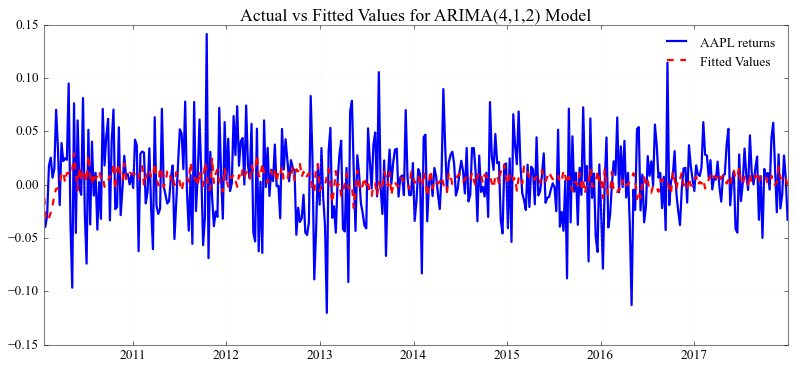

In [118]:
arima_fitted_values = auto_arima_model.fittedvalues()

# Plotting the actual vs fitted values
plt.figure(figsize=(12, 5))
plt.plot(weekly_rt, label='AAPL returns')
plt.plot(arima_fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('Actual vs Fitted Values for ARIMA(4,1,2) Model')
plt.legend()
plt.show()

Ah! We finally start to see a model that captures more dynamics. Let's be realistic, it's still far from a desirable model but we are getting closer :) 

How does the predictions compares with the ARMA model? 

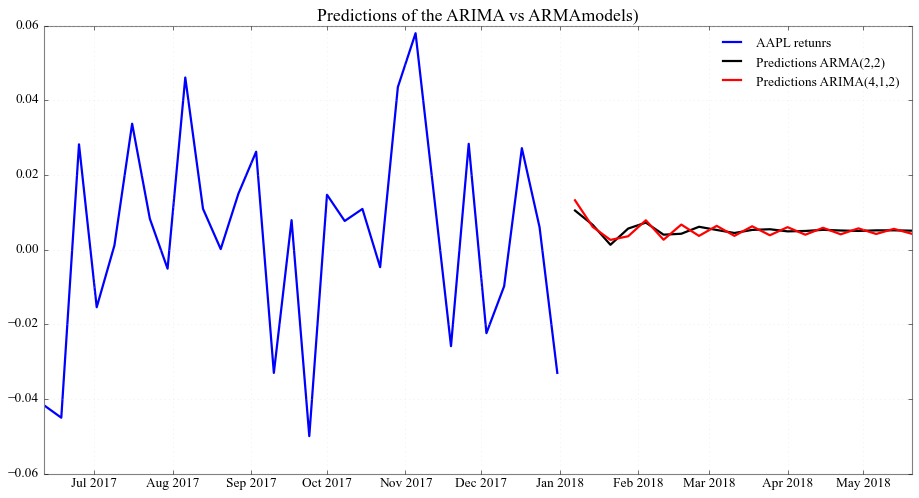

In [121]:
forecast_arima = auto_arima_model.predict(n_periods=20)

plt.figure(figsize=(14, 7))
plt.plot(weekly_rt[-30:], label='AAPL retunrs', color='blue')
plt.plot(forecast_arma.predicted_mean, label='Predictions ARMA(2,2)', color='black')
plt.plot(forecast_arima, label='Predictions ARIMA(4,1,2)', color='red')
plt.title('Predictions of the ARIMA vs ARMAmodels)')
plt.legend()
plt.show()

We are again faced with reality :) It's clear that, even if the model is getting slowly better, we are still far from a good model. 

The reason is straightforward though. The stock market is too random for us to be able to predict it just using past values from the same asset. 

But, different assets are correlated, what if we could use that feature to create better models? That's when ARIMAX models come into play :) 

## ARIMAX: Adding exogenous variables to your ARIMA model
***

The "X" in ARIMAX stands for "exogenous," referring to the external variables included in the model. These variables can represent anything that might influence the series you're forecasting but is not directly a part of it, such as economic indicators, weather conditions, holidays, or promotional activities for sales forecasts. The ARIMAX model can be described by the following equation:


$$(1 - \sum_{i=1}^{p} \phi_i L^i) (1 - L)^d Y_t = c + (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t + \sum_{k=1}^{n} \beta_k X_{k,t}$$

where:
- $Y_t$ is the time series at time \(t\),
- $L$ is the lag operator,
- $\phi_i$ are the coefficients of the AR terms,
- $d$ is the degree of differencing,
- $\theta_j$ are the coefficients of the MA terms,
- $c$ is a constant,
- $\epsilon_t$ is the error term at time \(t\),
- $X_{k,t}$ represents the $k$-th exogenous variable at time \(t\),
- $\beta_k$ are the coefficients associated with the \(k\)-th exogenous variable, indicating the impact of these variables on the dependent variable.


The question is now: What kind of variables would help me to model AAPL stock returns? 

It turns out there are so much options for you to choose from :) Here are a few: 


1. **Market Indices:**
   - **S&P 500 Index:** As a broad representation of the market, movements in the S&P 500 can impact individual stocks.
   - **NASDAQ Composite Index:** Given that AAPL is a tech-heavy stock, the NASDAQ's performance might be particularly relevant.
   - **Dow Jones Industrial Average (DJIA):** Although less tech-focused, the DJIA can still reflect overall market sentiment.

2. **Sector Indices:**
   - **Technology Sector Indices:** Such as the NASDAQ-100 Technology Sector Index, can provide insight into the sector's performance.
   - **Semiconductor Index:** Given Apple’s reliance on semiconductor components, indices like the Philadelphia Semiconductor Index (SOX) could be relevant.

3. **Economic Indicators:**
   - **Consumer Confidence Index:** Reflects consumer sentiment, which can impact consumer spending on tech products.
   - **Gross Domestic Product (GDP):** General economic health can influence stock performance.
   - **Interest Rates:** The Federal Funds Rate, for example, affects borrowing costs and investment appetite.

4. **Company-Specific Data:**
   - **Earnings Releases and Surprises:** Quarterly earnings reports and whether Apple meets, exceeds, or misses analyst expectations.
   - **Product Launch Events:** Significant product announcements can lead to stock price volatility.
   - **Supply Chain Information:** Issues such as chip shortages or production delays can impact stock prices.

5. **Tech Industry Trends:**
   - **Smartphone Market Trends:** Given the iPhone's importance to Apple’s revenue.
   - **Innovation Indexes or Patent Filings:** Indicators of Apple’s or its competitors’ innovation activities.

6. **Geopolitical and Regulatory Factors:**
   - **Trade Policies:** Tariffs and trade relations, especially between the U.S. and China, can affect Apple's manufacturing and sales.
   - **Regulatory Changes:** In the tech sector, such as privacy laws or antitrust investigations.


Let's try with an easy one: the SP500 returns. It is an easy one because we are recreating some kind of CAPM (see notebook about market models :)) and it is an index so well-known that it is very simple to get its historical returns! 

In [122]:
sp500 = fyf.download('^GSPC', '2010-01-01', '2018-01-01')['Adj Close']

# let's study weekly stock returns 
weekly_sp500 = sp500.resample('W').last()
weekly_rt_sp500 = weekly_sp500.pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


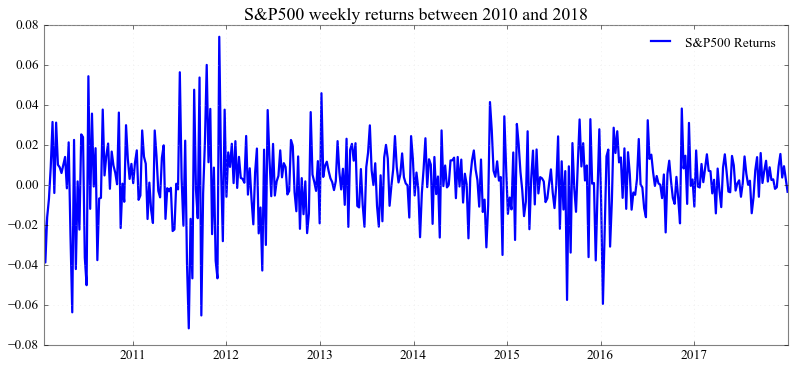

In [124]:
plt.figure(figsize=(12,5))
plt.title('S&P500 weekly returns between 2010 and 2018')
plt.plot(weekly_rt_sp500, label='S&P500 Returns')
plt.legend()
plt.show()

let's now include that in our ARIMA model to make it ARIMAX :) 

In [135]:
arimax_model = sm.tsa.SARIMAX(weekly_rt, 
                       order=(4, 1, 2), 
                       exog=weekly_rt_sp500,
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

In [136]:
fit_arimax = arimax_model.fit()
fit_arimax.summary()

C:\Users\Mathis Mourey\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  416
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 843.013
Date:                Sat, 30 Mar 2024   AIC                          -1670.025
Time:                        14:02:13   BIC                          -1637.876
Sample:                    01-17-2010   HQIC                         -1657.308
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Adj Close      1.0776      0.083     13.014      0.000       0.915       1.240
ar.L1         -0.6649      0.982     -0.677      0.498      -2.590       1.260
ar.L2         -0.0559      0.093     -0.600      0.548      -0.239       0.127
ar.L3          0.0835      0.064      1.298      0.194      -0.043       0.210
ar.L4          0.0822      0.085      0.972      0.331      -0.083       0.248
ma.L1         -0.3994      0.957     -0.417      0.677      -2.276       1.477
ma.L2         -0.6009      1.039     -0.579      0.563      -2.636       1.435
sigma2         0.0010      0.000      3.332      0.001       0.000       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                51.50
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.07
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

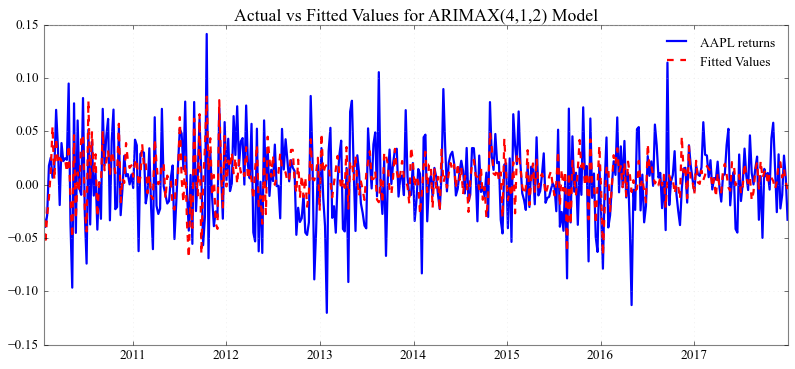

In [138]:
arimax_fitted_values = fit_arimax.fittedvalues

# Plotting the actual vs fitted values
plt.figure(figsize=(12, 5))
plt.plot(weekly_rt, label='AAPL returns')
plt.plot(arimax_fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('Actual vs Fitted Values for ARIMAX(4,1,2) Model')
plt.legend()
plt.show()